In [ ]:
!pip install SimpleITK


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

import SimpleITK as sitk

from google.colab.patches import cv2_imshow

In [ ]:
import inspect
path = "/content/drive/Shareddrives/IA DL_project/ML IA/IMAGE_PROCESSING_PIPELINE"

if path not in sys.path:
  sys.path.append(path)

import luna_module
from luna_module import *


# List all function names in the luna_module
function_names = [name for name, obj in inspect.getmembers(luna_module) if inspect.isfunction(obj)]

print(function_names)

['annotations_by_uid', 'binarize_lung', 'binarize_lung_3d', 'binary_closing', 'binary_dilation', 'binary_erosion', 'binary_fill_holes', 'binary_opening', 'center_of_mass', 'clear_border', 'convert_annotation_df', 'convert_annotation_df_with_uid', 'create_3d_mask', 'create_annotations_mask', 'create_annotations_mask_by_uid', 'create_patch', 'debugger', 'draw_ellipsoid', 'find_by_uid', 'find_neighborhood_indices', 'find_neighborhood_indices_more_precise', 'get_slice_candidates', 'get_slice_candidates_old', 'get_slices', 'get_uids', 'img_by_uid', 'masked_annotations_by_uid', 'masked_annotations_with_info_by_uid', 'meta_by_uid', 'norm2float', 'norm2uint16', 'norm2uint8', 'normalize_intensity', 'plot_slices', 'process_slice_candidates', 'process_slice_candidates_old', 'process_slices', 'remove_non_central_objects', 'sensitivity_score', 'sensitivity_score_more_precise', 'show_3_images', 'subset_by_uid', 'unwanted_object_filter']


# LOAD IN IMAGES

In [ ]:
LUNA_PATH = os.path.join(os.getcwd(), "drive", "Shareddrives", "IA DL_project", "ML IA", "LUNA16")

SUBSETS_PATH = os.path.join(LUNA_PATH, "subsets") # path for subsets folder
SUBSETS = os.listdir(SUBSETS_PATH) # subset folders present
SUBSET = "subset0"

ANNOTATIONS_DF = pd.read_csv(os.path.join(LUNA_PATH, f"{SUBSET}_annotations_expanded.csv"), index_col="Unnamed: 0")

In [ ]:
image_dict = {}

In [ ]:
read_in_num = 35

subset_path = lambda subset: os.path.join(SUBSETS_PATH, subset)
file_path = lambda subset, filename: os.path.join(SUBSETS_PATH, subset, filename)

for i, subset in enumerate(SUBSETS):
  if subset != SUBSET:
    break

  # Create subset key if it doesn't exist
  if subset not in image_dict:
    image_dict[subset] = {}

  # Iterate through all the keys in the subset
  read_in = 0
  for j, filename in enumerate(os.listdir(subset_path(subset))):
    # if j < 8: continue # Do not read in before the third file (they have annotations)

    name, extension = os.path.splitext(filename) # Separate filename and extension

    if extension != ".mhd":
      continue

    if not len(annotations_by_uid(name, ANNOTATIONS_DF)):
      print(f"[SKIP] - no annotations for {name}")
      continue

    # Only read if there is missing information
    if name not in image_dict[subset]:
      print(f"[START] -- READING IN: {subset}/{name}")
      image = sitk.ReadImage(os.path.join(SUBSETS_PATH, subset, filename))

      image_dict[subset][name] = image
      print(f"[DONE] -- READING IN: {subset}/{name}")

    else:
      print(f"[SKIP] -- ALREADY EXISTS: {subset}/{name}")
      continue

    read_in += 1 # Increment file-read-in counter
    if read_in >= read_in_num: break # If desired read-ins are reached for loop is broken in the subset

  print(f"[STATUS] -- READ IN {read_in_num} entries in {subset}")


subset_keys = list(image_dict.keys()) # Extract the stored subset-keys
filename_keys = [list(image_dict[key].keys()) for key in subset_keys] # Extract the stored filename-keys
filename_keys_flat = list(np.array(filename_keys).ravel())#[*filename_keys[0], *filename_keys[1],] # Flatten the stored filename-keys

print(f"\n")
print(f"Subset keys: {subset_keys}")
print(f"Subset lengths: {[len(image_dict[key]) for key in subset_keys]}")
print(f"Filename keys: {filename_keys_flat}")

[SKIP] - no annotations for 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260
[START] -- READING IN: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492
[DONE] -- READING IN: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492
[START] -- READING IN: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059
[DONE] -- READING IN: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059
[START] -- READING IN: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987
[DONE] -- READING IN: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987
[SKIP] - no annotations for 1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720
[START] -- READING IN: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565
[DONE] -- READING IN: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565
[SKIP] - no annotations for 1.3.6.1.4.1.14519.5.2.

# ANNOTATIONS DATAFRAME

In [ ]:
current_files = [key for keys in filename_keys for key in keys]
filtered_df = ANNOTATIONS_DF[ANNOTATIONS_DF["seriesuid"].isin(current_files)]
filtered_df

,seriesuid,coordX,coordY,coordZ,diameter_mm,origin(xyz),spacing(xyz),cartesian_coords(zyx),cartesian_diameters(zyx),patch_boundaries
23,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.567944,67.260517,-231.816619,6.440879,"(-182.5, -190.0, -313.75)","(0.7421879768371582, 0.7421879768371582, 2.5)","(33, 347, 110)","(3, 9, 9)","((94, 331), (126, 363))"
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,"(-187.699997, -108.300003, -194.0)","(0.5488280057907104, 0.5488280057907104, 1.25)","(68, 286, 426)","(11, 25, 25)","((410, 270), (442, 302))"
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,"(-187.699997, -108.300003, -194.0)","(0.5488280057907104, 0.5488280057907104, 1.25)","(57, 337, 408)","(3, 8, 8)","((392, 321), (424, 353))"
28,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.434059,117.765579,-181.947817,4.681382,"(-180.600006, -143.100006, -298.774994)","(0.7421879768371582, 0.7421879768371582, 0.625)","(187, 351, 427)","(7, 6, 6)","((411, 335), (443, 367))"
86,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,145.967465,-161.197634,-312.071347,6.378436,"(-184.638671875, -326.638671875, -385.2)","(0.72265625, 0.72265625, 1.7999999523162842)","(41, 229, 457)","(4, 9, 9)","((441, 213), (473, 245))"
...,...,...,...,...,...,...,...,...,...,...
795,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-70.851189,43.232739,-161.903079,5.103332,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(143, 287, 91)","(4, 10, 10)","((75, 271), (107, 303))"
796,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-65.853558,81.310802,-179.945889,4.091254,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(129, 359, 101)","(3, 8, 8)","((85, 343), (117, 375))"
797,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-78.608736,83.603167,-180.331341,3.604122,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(128, 364, 77)","(3, 7, 7)","((61, 348), (93, 380))"
798,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-68.579078,88.634206,-190.872618,4.364981,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(120, 373, 96)","(3, 8, 8)","((80, 357), (112, 389))"


In [ ]:
uids = get_uids(image_dict)
uids = pd.Series(np.zeros((len(uids)), int), index=uids)

ann = filtered_df["seriesuid"].value_counts()

all = ann.combine_first(uids).astype(int)

print("Annotations for each case")
print((all))

print("Annotations for each case (nonzero)")
print((all[all>0]))


Annotations for each case
1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059    2
1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441    4
1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097    2
1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762    1
1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227

# MIGHT USE LATER (NOT JUST THE CENTER SLICES, BUT THE HOLE SPHERE (with area > 20))

In [ ]:
# uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441"
#
# img_3d = img_by_uid(uid, image_dict)
#
# mask_3d, indexes, centers, diameters  = create_annotations_mask_by_uid(uid, image_dict, filtered_df)
# #print(mask_3d)
# mask_3d = mask_3d.astype(bool)

In [ ]:
# z_slices = []
#
# def get_z_slices(mask_3d):
#   z_slices = []
#   for z in range(mask_3d.shape[0]):
#     slice_ =  mask_3d[z,:,:]
#     nonzeros = len(np.nonzero(slice_)[0])
#
#     if len(np.nonzero(slice_)[0]):
#       # print(f"Annotation at slice {z}!")
#       # print(f"Nonzero count: {nonzeros}")
#       if nonzeros > 20:
#         z_slices.append(z)
#   return z_slices
#
#
#
# z_slices = get_z_slices(mask_3d)
# print(f"Count:{len(z_slices)}")
# pass
#

In [ ]:
# z_slices = get_z_slices(mask_3d)
#
# mask_slices = mask_3d[z_slices,:,:]
# print(mask_slices.shape)
# img_slices = img_3d[z_slices,:,:]
# print(img_slices.shape)
#
# pairs = []
# for i in range(len(z_slices)):
#   pairs.append(img_slices[i])
#   pairs.append(mask_slices[i])
#
#   masked = img_slices[i].copy()
#   masked[~mask_slices[i]] = img_slices[i].min()
#   print(np.unique(masked))
#   pairs.append(masked)
#
# plot_slices(pairs, 3)
#

# ONLY THE CENTER Z_SLICES : Annotation & patch creation

In [ ]:
uid = filename_keys_flat[19]

[[199 185 318]
 [103 335 407]
 [212 308 386]]
(3, 512, 512)
(3, 512, 512)
[-1000  -927  -915  -911  -903  -896  -875  -873  -872  -862  -861  -858
  -822  -817  -797  -792  -785  -778  -764  -753  -752  -731  -717  -716
  -714  -713  -710  -702  -694  -681  -679  -676  -669  -666  -665  -645
  -640  -637  -624  -618  -615  -608  -597  -586  -578  -564  -555  -547
  -539  -537  -530  -528  -524  -518  -517  -514  -507  -505  -502  -501
  -500  -497  -493  -491  -489  -484  -475  -474  -473  -468  -454  -432
  -431  -416  -413  -408  -396  -379  -372  -371  -370  -364  -355  -352
  -337  -326  -325  -320  -319  -309  -298  -296  -293  -286  -279  -272
  -271  -270  -266  -265  -257  -252  -248  -233  -229  -220  -215  -213
  -209  -207  -203  -190  -173  -170  -168  -163  -159  -157  -148  -144
  -142  -137  -136  -126  -109  -105  -104  -103  -101   -89   -86   -84
   -82   -80   -75   -73   -68   -59   -56   -55   -52   -49   -47   -44
   -42   -40   -32   -23   -19   -13   -10    -9  

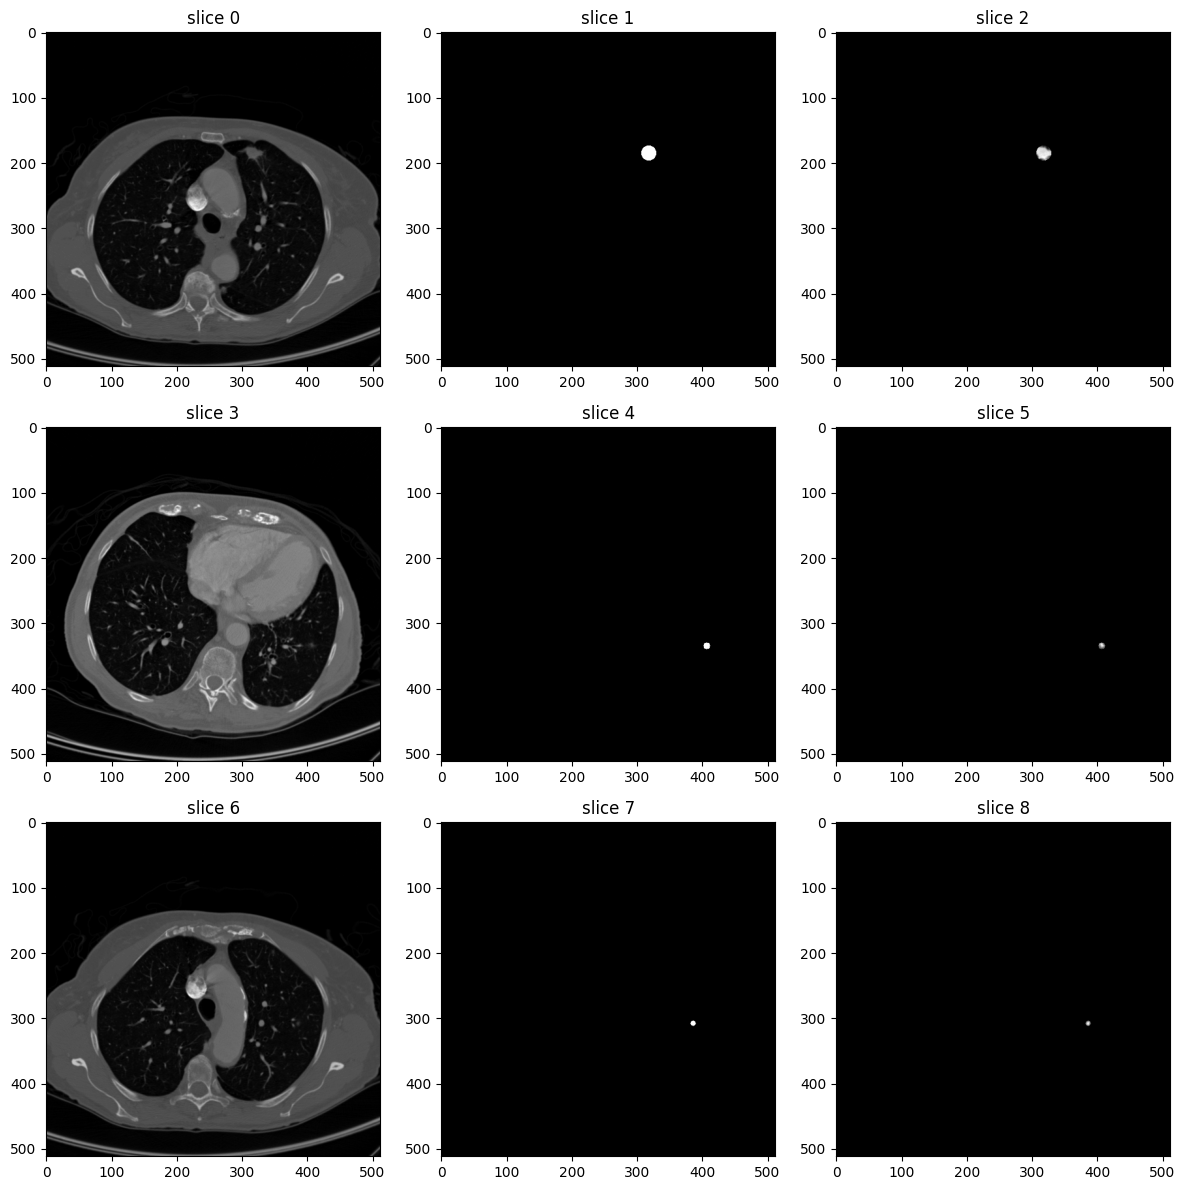

In [ ]:
img_3d = img_by_uid(uid, image_dict)
mask_3d = binarize_lung_3d(img_3d)

mask_3d, indexes, centers, diameters = create_annotations_mask_by_uid(uid, image_dict, filtered_df, verbose=False)
mask_3d = mask_3d.astype(bool)

print(centers)
if not len(centers):
  print(f"NO ANNOTATION FOR CASE {filename_keys_flat[15]}")
  pass

center_z_slices = centers[:, 0]


mask_slices = mask_3d[center_z_slices,:,:]
print(mask_slices.shape)
img_slices = img_3d[center_z_slices,:,:]
print(img_slices.shape)

pairs = []
for i in range(len(center_z_slices)):
  pairs.append(img_slices[i])
  pairs.append(mask_slices[i])

  masked = img_slices[i].copy()
  masked[~mask_slices[i]] = img_slices[i].min()
  print(np.unique(masked))
  pairs.append(masked)

plot_slices(pairs, 3)

Pixel intensities on masked image
[-1000  -927  -915  -911  -903  -896  -875  -873  -872  -862  -861  -858
  -822  -817  -797  -792  -785  -778  -764  -753  -752  -731  -717  -716
  -714  -713  -710  -702  -694  -681  -679  -676  -669  -666  -665  -645
  -640  -637  -624  -618  -615  -608  -597  -586  -578  -564  -555  -547
  -539  -537  -530  -528  -524  -518  -517  -514  -507  -505  -502  -501
  -500  -497  -493  -491  -489  -484  -475  -474  -473  -468  -454  -432
  -431  -416  -413  -408  -396  -379  -372  -371  -370  -364  -355  -352
  -337  -326  -325  -320  -319  -309  -298  -296  -293  -286  -279  -272
  -271  -270  -266  -265  -257  -252  -248  -233  -229  -220  -215  -213
  -209  -207  -203  -190  -173  -170  -168  -163  -159  -157  -148  -144
  -142  -137  -136  -126  -109  -105  -104  -103  -101   -89   -86   -84
   -82   -80   -75   -73   -68   -59   -56   -55   -52   -49   -47   -44
   -42   -40   -32   -23   -19   -13   -10    -9    -5     2     5    14
    16    17    2

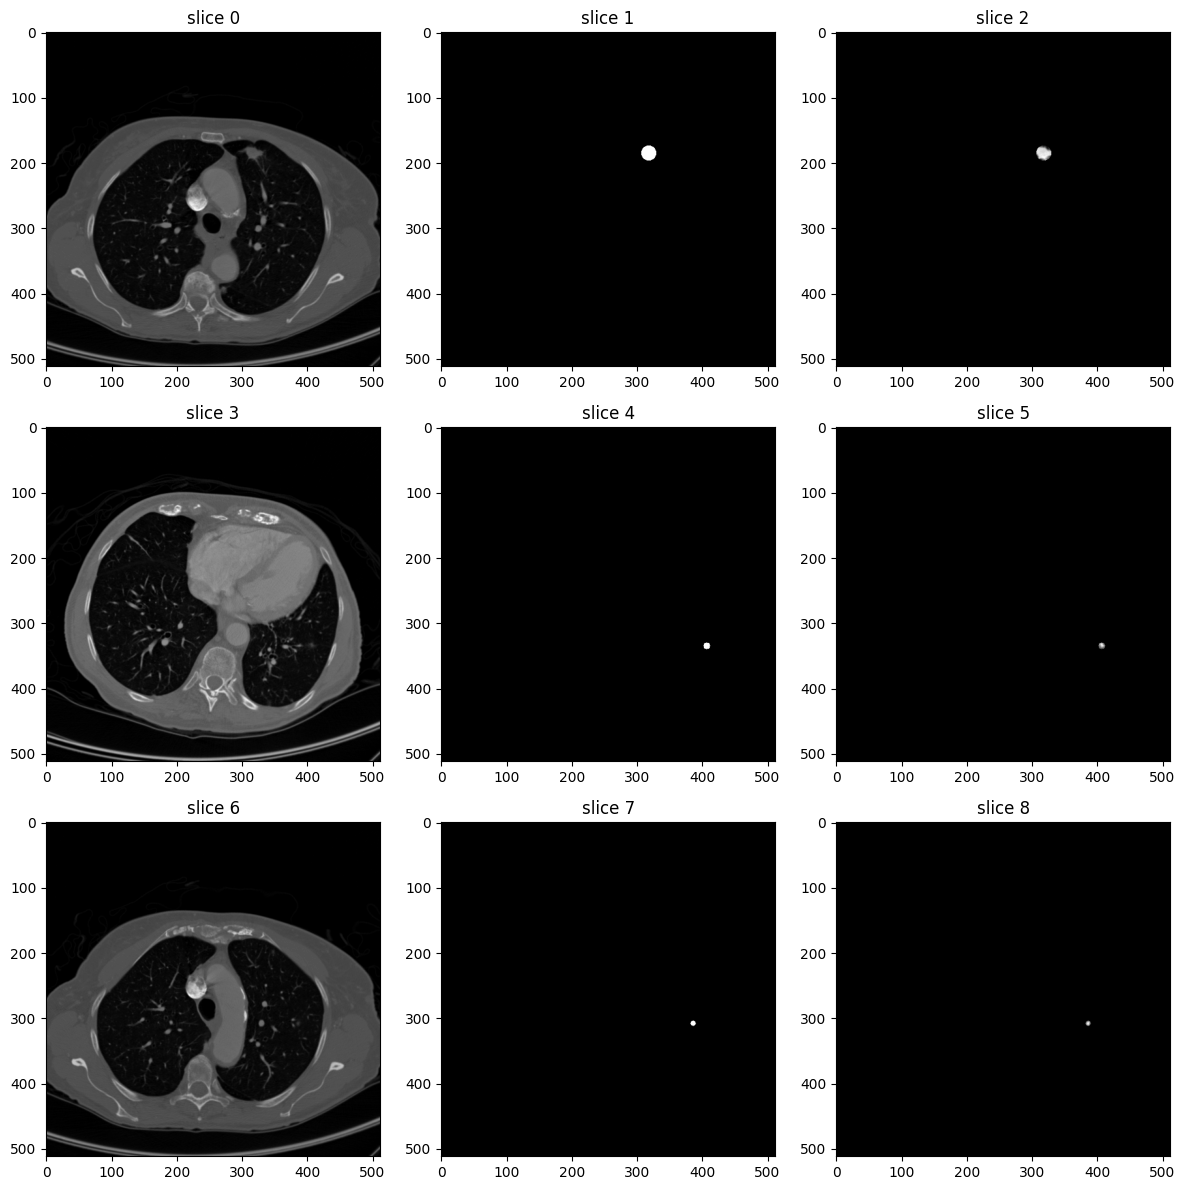

(3, 512, 512)
[454 455 456]
[[199 185 318]
 [103 335 407]
 [212 308 386]]
[[14. 23. 23.]
 [ 6. 10. 10.]
 [ 5.  8.  8.]]


In [ ]:
res = masked_annotations_with_info_by_uid(uid, image_dict, filtered_df, True)
print(res[0].shape)
print(res[1])
print(res[2])
print(res[3])

In [ ]:
# Copy the filtered DataFrame
expanded_annotations_df = filtered_df.copy()

# Create a series of NaNs with the same index as new_df
na_series = pd.Series(np.full((len(expanded_annotations_df)), np.nan), index=expanded_annotations_df.index, dtype=object)

# Initialize the new columns with NaN values
expanded_annotations_df["origin(xyz)"] = na_series
expanded_annotations_df["spacing(xyz)"] = na_series
expanded_annotations_df["cartesian_coords(zyx)"] = na_series
expanded_annotations_df["cartesian_diameters(zyx)"] = na_series
expanded_annotations_df["patch_boundaries"] = na_series

# Iterate through the rows and update the DataFrame
for row_i, row in expanded_annotations_df.iterrows():
    masked, indexes, centers, diameters = masked_annotations_with_info_by_uid(row["seriesuid"], image_dict, filtered_df)
    for i, index in enumerate(indexes):

        origin, spacing = meta_by_uid(row["seriesuid"], image_dict)
        expanded_annotations_df.at[index, "origin(xyz)"] = origin
        expanded_annotations_df.at[index, "spacing(xyz)"] = spacing

        expanded_annotations_df.at[index, "cartesian_coords(zyx)"] = tuple(np.array(centers[i], dtype=int).tolist())
        expanded_annotations_df.at[index, "cartesian_diameters(zyx)"] = tuple(np.array(diameters[i], dtype=int).tolist())


# Display the updated DataFrame to verify the changes
(expanded_annotations_df)

,seriesuid,coordX,coordY,coordZ,diameter_mm,origin(xyz),spacing(xyz),cartesian_coords(zyx),cartesian_diameters(zyx),patch_boundaries
23,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.567944,67.260517,-231.816619,6.440879,"(-182.5, -190.0, -313.75)","(0.7421879768371582, 0.7421879768371582, 2.5)","(33, 347, 110)","(3, 9, 9)",NaN
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,"(-187.699997, -108.300003, -194.0)","(0.5488280057907104, 0.5488280057907104, 1.25)","(68, 286, 426)","(11, 25, 25)",NaN
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,"(-187.699997, -108.300003, -194.0)","(0.5488280057907104, 0.5488280057907104, 1.25)","(57, 337, 408)","(3, 8, 8)",NaN
28,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.434059,117.765579,-181.947817,4.681382,"(-180.600006, -143.100006, -298.774994)","(0.7421879768371582, 0.7421879768371582, 0.625)","(187, 351, 427)","(7, 6, 6)",NaN
86,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,145.967465,-161.197634,-312.071347,6.378436,"(-184.638671875, -326.638671875, -385.2)","(0.72265625, 0.72265625, 1.7999999523162842)","(41, 229, 457)","(4, 9, 9)",NaN
...,...,...,...,...,...,...,...,...,...,...
795,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-70.851189,43.232739,-161.903079,5.103332,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(143, 287, 91)","(4, 10, 10)",NaN
796,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-65.853558,81.310802,-179.945889,4.091254,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(129, 359, 101)","(3, 8, 8)",NaN
797,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-78.608736,83.603167,-180.331341,3.604122,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(128, 364, 77)","(3, 7, 7)",NaN
798,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-68.579078,88.634206,-190.872618,4.364981,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(120, 373, 96)","(3, 8, 8)",NaN


In [ ]:
cases_df = pd.DataFrame(index=filename_keys_flat)

na_series = pd.Series(np.full((len(cases_df)), np.nan), index=cases_df.index, dtype=object)
cases_df["annotation_indexes"] = na_series
cases_df["centers(zyx)"] = na_series
cases_df["diameters(zyx)"] = na_series
cases_df["shape(zyx)"] = na_series


for seriesuid in cases_df.index:
  #print(seriesuid)
  indexes = expanded_annotations_df[expanded_annotations_df["seriesuid"]==seriesuid].index
  # print(indexes)
  cases_df.at[seriesuid, "annotation_indexes"] = indexes.tolist()

  #origin, spacing = meta_by_uid(seriesuid, image_dict)
  img = img_by_uid(seriesuid, image_dict)

  # cases_df.at[seriesuid, "origin(xzy)"] = origin
  # cases_df.at[seriesuid, "spacing(xyz)"] = spacing
  cases_df.at[seriesuid, "shape(zyx)"] = img.shape

  centers = []
  diameters = []
  for i in indexes:
    centers.append(expanded_annotations_df.at[i, "cartesian_coords(zyx)"])
    diameters.append(expanded_annotations_df.at[i, "cartesian_diameters(zyx)"])
  cases_df.at[seriesuid, "centers(zyx)"] = centers
  cases_df.at[seriesuid, "diameters(zyx)"] = diameters

cases_df

,annotation_indexes,centers(zyx),diameters(zyx),shape(zyx)
1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492,[23],"[(33, 347, 110)]","[(3, 9, 9)]","(119, 512, 512)"
1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059,"[25, 26]","[(68, 286, 426), (57, 337, 408)]","[(11, 25, 25), (3, 8, 8)]","(161, 512, 512)"
1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987,[28],"[(187, 351, 427)]","[(7, 6, 6)]","(538, 512, 512)"
1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565,[86],"[(41, 229, 457)]","[(4, 9, 9)]","(195, 512, 512)"
1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354,[98],"[(525, 264, 366)]","[(13, 11, 11)]","(672, 512, 512)"
1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912,[103],"[(101, 382, 323)]","[(4, 15, 15)]","(133, 512, 512)"
1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950,[110],"[(370, 354, 117)]","[(10, 11, 11)]","(483, 512, 512)"
1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843,[117],"[(223, 270, 389)]","[(4, 8, 8)]","(274, 512, 512)"
1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441,"[129, 130, 131, 132]","[(101, 207, 179), (153, 321, 195), (161, 274, ...","[(6, 8, 8), (6, 9, 9), (7, 11, 11), (5, 8, 8)]","(197, 512, 512)"
1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097,"[135, 136]","[(92, 308, 82), (90, 349, 113)]","[(11, 15, 15), (18, 24, 24)]","(246, 512, 512)"


In [ ]:
def create_patch(img, patch_center, patch_size=48):
    """
    Creates a patch from the input image centered at the given coordinates.
    If the patch extends beyond the image boundaries, the out-of-bound areas
    are filled with the air threshold value.

    Parameters:
    img (ndarray): Input image.
    patch_center (tuple): Coordinates (x, y) of the patch center.
    patch_size (int): Size of the patch (default is 48).

    Returns:
    patch (ndarray): The extracted patch from the image, with out-of-bound areas filled.
    coords (tuple): Coordinates of the top-left and bottom-right corners of the patch.
    """
    im = img.copy()  # Make a copy of the input image to avoid modifying the original
    x, y = patch_center
    from_center = patch_size / 2

    # Calculate top-left and bottom-right coordinates of the patch
    tl_y, tl_x = int(y - from_center), int(x - from_center)
    br_y, br_x = int(y + from_center), int(x + from_center)

    # Pad the image if necessary
    pad_y = max(0, -tl_y, br_y - im.shape[0])
    pad_x = max(0, -tl_x, br_x - im.shape[1])

    if pad_y > 0 or pad_x > 0:
        im = np.pad(im, ((pad_y, pad_y), (pad_x, pad_x)),
                    mode='constant', constant_values=AIR_TH)
        tl_y += pad_y
        tl_x += pad_x
        br_y += pad_y
        br_x += pad_x

    # Extract the patch from the image
    patch = im[tl_y:br_y, tl_x:br_x]

    return patch, ((tl_x, tl_y), (br_x, br_y))

In [ ]:
patch_size = 48
from_center = patch_size / 2

# NOTE: I got confused with x and y, it may be wrong
patch_from_center = lambda x, y: ((int(y-from_center), int(x-from_center)), (int(y+from_center), int(x+from_center)))

slices = []
maskeds = []
patch_masks = []
patches = []
patch_cuts = []

for i, row in cases_df.iterrows():
  # Select case
  img = img_by_uid(i, image_dict)


  #mask = lung_mask_3d(img)
  #masked = img.copy()
  #masked[mask==False] = AIR_TH

  # Get annotation centers for case
  centers = cases_df.at[i, "centers(zyx)"]

  # Get annotation indexes for case
  annotation_indexes = cases_df.at[i, "annotation_indexes"]

  # Loop through annotations
  if len(annotation_indexes):
    for j, center3d in enumerate(centers):
      z, center = center3d[0], center3d[1:3] # Get slice index and x,y center
      z_slice = img[z,:,:] # Select slice
      z_slice[z_slice < AIR_TH] = AIR_TH # Clip minimum intensity
      slices.append(z_slice) # Store

      mask_slice = binarize_lung(z_slice)
      mask_slice = binary_closing(mask_slice, morphology.disk(21))
      masked_slice = z_slice.copy()
      masked_slice[mask_slice==False] = AIR_TH
      maskeds.append(masked_slice)

      # Create patch for annotation
      cut, bbox = create_patch(z_slice, (center[1], center[0]))
      cut_masked, bbox = create_patch(masked_slice, (center[1], center[0]))
      patch_cuts.append(cut_masked)

      # Store cartesian bbox for annotation in the DataFrame
      tl, br = bbox
      expanded_annotations_df.at[annotation_indexes[j], "patch_boundaries"] = (tl, br)

      # Create mask on original slice of the patch
      patch_mask = np.zeros_like(z_slice, dtype=float)
      cv.rectangle(patch_mask, tl, br, 1, -1)
      patch_masks.append(patch_mask.astype(bool))

      # Create masked image of slice using the patch
      patch_masked = masked_slice.copy()
      patch_masked = z_slice.copy()
      #patch_masked[patch_mask==False] = AIR_TH
      patches.append(cut)

In [ ]:
expanded_annotations_df

,seriesuid,coordX,coordY,coordZ,diameter_mm,origin(xyz),spacing(xyz),cartesian_coords(zyx),cartesian_diameters(zyx),patch_boundaries
23,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.567944,67.260517,-231.816619,6.440879,"(-182.5, -190.0, -313.75)","(0.7421879768371582, 0.7421879768371582, 2.5)","(33, 347, 110)","(3, 9, 9)","((86, 323), (134, 371))"
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,"(-187.699997, -108.300003, -194.0)","(0.5488280057907104, 0.5488280057907104, 1.25)","(68, 286, 426)","(11, 25, 25)","((402, 262), (450, 310))"
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,"(-187.699997, -108.300003, -194.0)","(0.5488280057907104, 0.5488280057907104, 1.25)","(57, 337, 408)","(3, 8, 8)","((384, 313), (432, 361))"
28,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.434059,117.765579,-181.947817,4.681382,"(-180.600006, -143.100006, -298.774994)","(0.7421879768371582, 0.7421879768371582, 0.625)","(187, 351, 427)","(7, 6, 6)","((403, 327), (451, 375))"
86,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,145.967465,-161.197634,-312.071347,6.378436,"(-184.638671875, -326.638671875, -385.2)","(0.72265625, 0.72265625, 1.7999999523162842)","(41, 229, 457)","(4, 9, 9)","((433, 205), (481, 253))"
...,...,...,...,...,...,...,...,...,...,...
795,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-70.851189,43.232739,-161.903079,5.103332,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(143, 287, 91)","(4, 10, 10)","((67, 263), (115, 311))"
796,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-65.853558,81.310802,-179.945889,4.091254,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(129, 359, 101)","(3, 8, 8)","((77, 335), (125, 383))"
797,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-78.608736,83.603167,-180.331341,3.604122,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(128, 364, 77)","(3, 7, 7)","((53, 340), (101, 388))"
798,1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214...,-68.579078,88.634206,-190.872618,4.364981,"(-118.900002, -107.400002, -340.859985)","(0.5253909826278687, 0.5253909826278687, 1.249...","(120, 373, 96)","(3, 8, 8)","((72, 349), (120, 397))"


In [ ]:
def show_3_images(images, cmap="gray"):
    """
    Show 3 images in 1 row
    """
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))

    axes[0].imshow(images[0], cmap=cmap)
    axes[0].axis('off')  # Turn off axis ticks and labels
    axes[1].imshow(images[1], cmap=cmap)
    axes[1].axis('off')  # Turn off axis ticks and labels
    axes[2].imshow(images[2], cmap=cmap)
    axes[2].axis('off')  # Turn off axis ticks and labels

    return fig, axes

In [ ]:
triplets = []

for i in range(len(patches)):
  #triplets.append(slices[i])
  #triplets.append(patch_masks[i])
  #triplets.append(patch_masks[i])
  #triplets.append(patch_cuts[i])
  show_3_images([slices[i],patch_masks[i],patches[i]])

#plot_slices(triplets, cols=3)

Output hidden; open in https://colab.research.google.com to view.

(184, 202)
(232, 250)
(73, 226, 208)
((184, 202), (232, 250))


seriesuid                   1.3.6.1.4.1.14519.5.2.1.6279.6001.275007193025...
coordX                                                             -29.741414
coordY                                                             -18.461668
coordZ                                                            -134.245952
diameter_mm                                                         17.988647
origin(xyz)                                          (-158.0, -158.0, -226.0)
spacing(xyz)                   (0.6171879768371582, 0.6171879768371582, 1.25)
cartesian_coords(zyx)                                          (73, 226, 208)
cartesian_diameters(zyx)                                         (14, 29, 29)
patch_boundaries                                     ((184, 202), (232, 250))
Name: 719, dtype: object

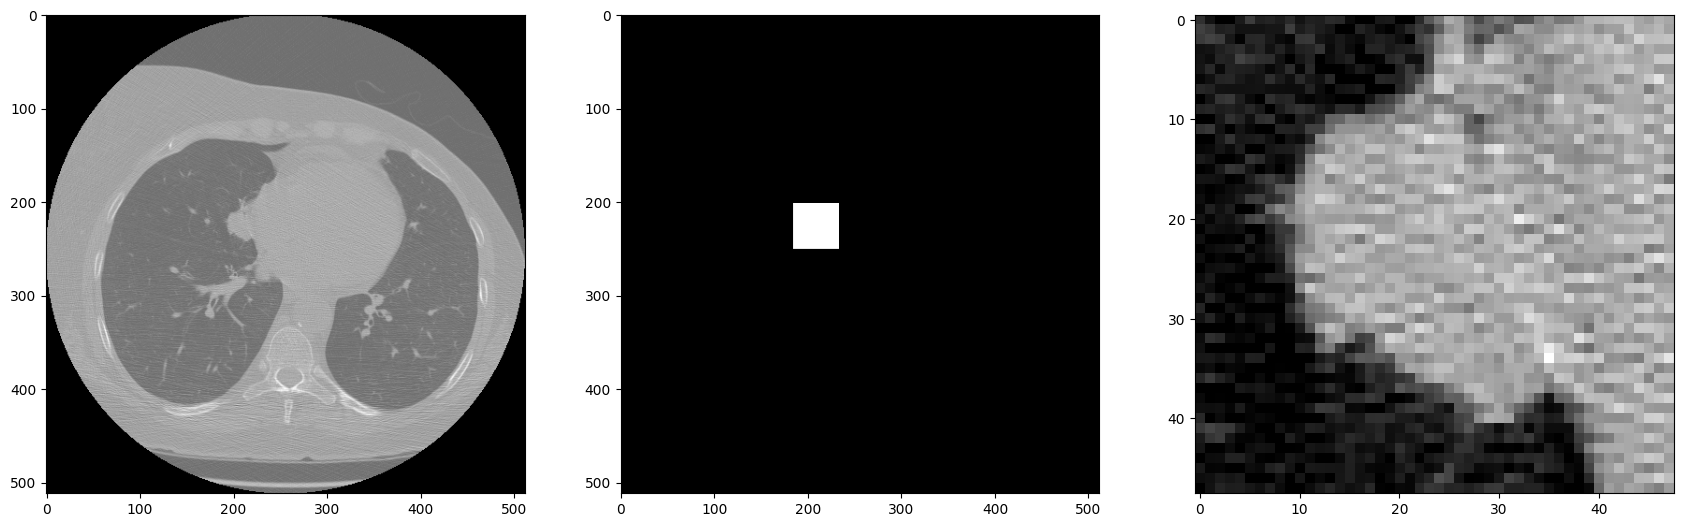

In [ ]:
row = expanded_annotations_df.iloc[76]
im = img_by_uid(row["seriesuid"], image_dict)

z, y, x = row["cartesian_coords(zyx)"]
tl, br = row["patch_boundaries"]
center = row["cartesian_coords(zyx)"]
print(tl)
print(br)
print(center)

z, center = center[0], center[1:3]


slice_ = im[z,:,:]

patch, bbox = create_patch(slice_, center)
print(bbox)


mask = np.zeros_like(slice_, dtype=float)
cv.rectangle(mask, tl, br, 1, -1)

#patch = slice_[tl[1]:br[1], tl[0]:br[0]]


show_3_images([slice_, mask, patch])
row

In [ ]:
save_path = os.path.join(path, f"subset{read_in_subset}_annotations_expanded.csv")

expanded_annotations_df.to_csv(save_path, index=True)

In [ ]:
# df = pd.read_csv(os.path.join(path, "subset0_annotations_expanded.csv"))

# (expanded_annotations_df["cartesian_diameters(zyx)"]).apply(lambda x, : print(x))
# print("\n")
# (df["cartesian_diameters(zyx)"]).apply(lambda x, : print(x))